<a href="https://colab.research.google.com/github/ronnieogwang/Self_Driving_car_course/blob/master/section10_behaviorcloning/Behaviorcloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/ronnieogwang/Self_Driving_car_course.git



In [28]:
!ls


driving_log.csv  IMG  Self_Driving_car_course


In [29]:
!pwd

/content/Self_Driving_car_course/section10_behaviorcloning/Data


In [30]:
!ls


driving_log.csv  IMG  Self_Driving_car_course


In [31]:
cd Self_Driving_car_course


/content/Self_Driving_car_course/section10_behaviorcloning/Data/Self_Driving_car_course


In [32]:
!ls

MNIST_DNN.ipynb  section10_behaviorcloning  Section6_Keras   section8_MNIST
README.md	 section5_Finding_lanes     section7_deepNN  section9_roadsigns


In [33]:
cd section10_behaviorcloning/Data

/content/Self_Driving_car_course/section10_behaviorcloning/Data/Self_Driving_car_course/section10_behaviorcloning/Data


In [34]:
!ls

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


In [36]:
#get data
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse','speed']
pd.set_option('display.max_colwidth', -1)  
data = pd.read_csv('driving_log.csv', names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_01_29_16_28_05_516.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_01_29_16_28_05_516.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_01_29_16_28_05_516.jpg,0.0,0.0,0,0.000080
1,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_01_29_16_28_05_621.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_01_29_16_28_05_621.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_01_29_16_28_05_621.jpg,0.0,0.0,0,0.000078
2,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_01_29_16_28_05_723.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_01_29_16_28_05_723.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_01_29_16_28_05_723.jpg,0.0,0.0,0,0.000078
3,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_01_29_16_28_05_828.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_01_29_16_28_05_828.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_01_29_16_28_05_828.jpg,0.0,0.0,0,0.000079
4,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_01_29_16_28_05_933.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_01_29_16_28_05_933.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_01_29_16_28_05_933.jpg,0.0,0.0,0,0.000080


In [37]:
#to clear the head from the file names
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_29_16_28_05_516.jpg,left_2020_01_29_16_28_05_516.jpg,right_2020_01_29_16_28_05_516.jpg,0.0,0.0,0,0.000080
1,center_2020_01_29_16_28_05_621.jpg,left_2020_01_29_16_28_05_621.jpg,right_2020_01_29_16_28_05_621.jpg,0.0,0.0,0,0.000078
2,center_2020_01_29_16_28_05_723.jpg,left_2020_01_29_16_28_05_723.jpg,right_2020_01_29_16_28_05_723.jpg,0.0,0.0,0,0.000078
3,center_2020_01_29_16_28_05_828.jpg,left_2020_01_29_16_28_05_828.jpg,right_2020_01_29_16_28_05_828.jpg,0.0,0.0,0,0.000079
4,center_2020_01_29_16_28_05_933.jpg,left_2020_01_29_16_28_05_933.jpg,right_2020_01_29_16_28_05_933.jpg,0.0,0.0,0,0.000080


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


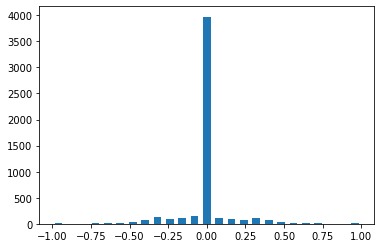

In [38]:
#visualize the steering angle
num_of_bins = 25  #number of classes/ranges of the histogram
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_of_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
print(center)

In [39]:
#remove excess 0 steering angle images
print('total data:', len(data))
remove_list = []
for j in range(num_of_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 5147
removed: 3773
remaining: 1374


In [40]:
#extract data
print(data.iloc[1])
datadir = 'IMG'
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir , data)


center      center_2020_01_29_16_28_47_209.jpg
left        left_2020_01_29_16_28_47_209.jpg  
right       right_2020_01_29_16_28_47_209.jpg 
steering    0                                 
throttle    0.487949                          
reverse     0                                 
speed       2.36403                           
Name: 57, dtype: object


In [41]:
#split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_val)))


Training Samples: 1099
Validation Samples: 275


Text(0.5, 1.0, 'Validation set')

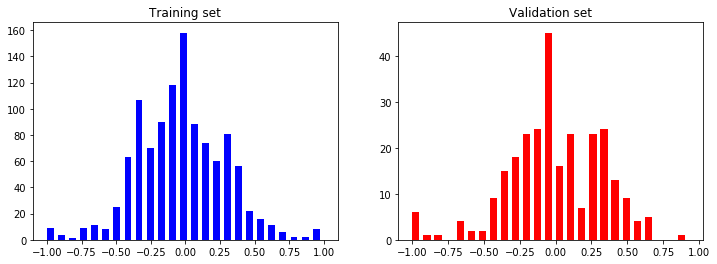

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_val, bins=num_of_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


In [0]:
#data preprocessing
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, : , :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

Text(0.5, 1, 'Preprocessed Image')

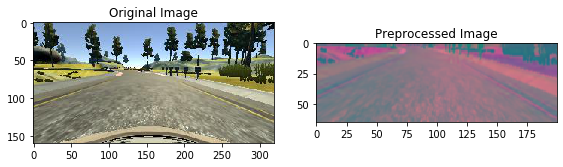

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

# We change the activatiion function fro relu to elu to avoid the dying gradient condition that occurs with relu for negative values. This is seen if the loss is not decreasing

In [58]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample = (2,2), input_shape = (66, 200, 3), activation = 'elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.compile(Adam(lr = 0.001), loss = 'mse')
    return model
    
model = nvidia_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [59]:
h = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), batch_size = 100, verbose = 1, shuffle = 1)


Train on 1099 samples, validate on 275 samples
Epoch 1/30
1099/1099 [==============================] - 1s 1ms/step - loss: 0.4619 - val_loss: 0.1053
Epoch 2/30
1099/1099 [==============================] - 0s 390us/step - loss: 0.1948 - val_loss: 0.1116
Epoch 3/30
1099/1099 [==============================] - 0s 369us/step - loss: 0.1510 - val_loss: 0.0992
Epoch 4/30
1099/1099 [==============================] - 0s 380us/step - loss: 0.1103 - val_loss: 0.0966
Epoch 5/30
1099/1099 [==============================] - 0s 355us/step - loss: 0.0980 - val_loss: 0.0925
Epoch 6/30
1099/1099 [==============================] - 0s 352us/step - loss: 0.0960 - val_loss: 0.0927
Epoch 7/30
1099/1099 [==============================] - 0s 343us/step - loss: 0.0922 - val_loss: 0.0893
Epoch 8/30
1099/1099 [==============================] - 0s 350us/step - loss: 0.0905 - val_loss: 0.0886
Epoch 9/30
1099/1099 [==============================] - 0s 343us/step - loss: 0.0876 - val_loss: 0.0867
Epoch 10/30
1099/10

Text(0.5, 0, 'Epoch')

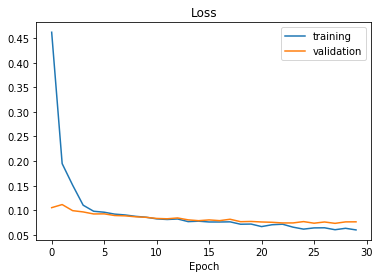

In [60]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')